In [106]:
import shutil
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

## Getting the list of files from API endpoint

In [107]:
url = f"http://localhost:3001/api/segmentation/list/m.zdanowicz@gmail.com"
response = requests.get(url)
list_of_files = json.loads(response.content)['list']
del response

list_of_files[:10]

['FISH1_BDNF488_10_DMSO_romi_10_CA',
 'FISH1_BDNF488_10_DMSO_romi_1_CA',
 'FISH1_BDNF488_10_DMSO_romi_4_CA',
 'FISH1_BDNF488_10_DMSO_romi_5_CA',
 'FISH1_BDNF488_10_DMSO_romi_6_CA',
 'FISH1_BDNF488_10_DMSO_romi_7_CA',
 'FISH1_BDNF488_10_DMSO_romi_8_CA',
 'FISH1_BDNF488_10_DMSO_romi_9_CA',
 'FISH1_BDNF488_1_cLTP_10_CA',
 'FISH1_BDNF488_1_cLTP_1_CA-Background subtraction-07']

## Function for segmentation loading

In [108]:
def loadSegmentationAPI(name):
    # https://stackoverflow.com/questions/13137817/how-to-download-image-using-requests
    url = f"http://localhost:3001/api/segmentation/file/m.zdanowicz@gmail.com/{name}"
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        # It would much better not to create any files here
        with open('tmp.npy', 'wb') as out_file:
            shutil.copyfileobj(response.raw, out_file)
        del response
        full_data = np.load('tmp.npy')
        return full_data
    else:
        raise Exception(f"Couldn't get the file from API (code {response.status_code})")

## Loading segmentation for some of the files

### First a little test

In [109]:
NAMES = list_of_files[:5]
NAMES

['FISH1_BDNF488_10_DMSO_romi_10_CA',
 'FISH1_BDNF488_10_DMSO_romi_1_CA',
 'FISH1_BDNF488_10_DMSO_romi_4_CA',
 'FISH1_BDNF488_10_DMSO_romi_5_CA',
 'FISH1_BDNF488_10_DMSO_romi_6_CA']

In [110]:
%%time

# For now a little evidence that it works correctly
path = f"/home/ubuntu/Projects/data/segmentation/m.zdanowicz@gmail.com/masks_3D_conv_clipped_{NAMES[0]}.npy"
full_data_disk = np.load(path)
full_data_api = loadSegmentationAPI(NAMES[0])
assert np.all(np.equal(full_data_disk, full_data_api)), "Wrong"

CPU times: user 29.2 ms, sys: 161 ms, total: 190 ms
Wall time: 11.4 s


In [111]:
%%time

# For now a little evidence that it raises exceptions in the right way
path = f"/home/ubuntu/Projects/data/segmentation/m.zdanowicz@gmail.com/masks_3D_conv_clipped_{NAMES[0]}.npy"
full_data_disk = np.load(path)
full_data_api = loadSegmentationAPI(NAMES[0]+"getting_error")
assert np.all(np.equal(full_data_disk, full_data_api)), "Wrong"

Exception: Couldn't get the file from API (code 404)

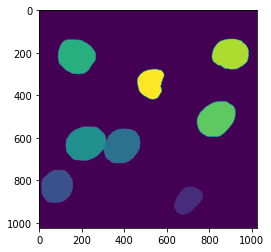

In [112]:
plt.imshow(full_data[23,:,:])

### Now a few files from one of the experiments

In [113]:
%%time

segmentations = {}
for name in tqdm(NAMES):
    segmentations[name] = loadSegmentationAPI(name)

100%|██████████| 5/5 [01:01<00:00, 12.31s/it]

CPU times: user 72.8 ms, sys: 552 ms, total: 625 ms
Wall time: 1min 1s


## Computing the volumes and their statistics

In [114]:
def computeVolumes(data):
    _, volumes = np.unique(data, return_counts=True)
    return volumes[1:]

In [115]:
%%time

volumes = [computeVolumes(segmentations[name]) for name in tqdm(NAMES)]

100%|██████████| 5/5 [00:06<00:00,  1.23s/it]

CPU times: user 5.81 s, sys: 340 ms, total: 6.15 s
Wall time: 6.14 s


## Populate a data frame for further processing

In [116]:
df = pd.DataFrame(index=NAMES)
df['volumes'] = volumes
df['no. of cells'] = df['volumes'].apply(lambda x: len(x))
df['avg. volume'] = df['volumes'].apply(lambda x: x.mean())
df['std. volume'] = df['volumes'].apply(lambda x: x.std())

In [118]:
global_volume_average = (df['volumes'].apply(lambda x: x.sum())).sum()/df['no. of cells'].sum()
glob